### Install and Import Packages

In [ ]:
!pip install pulp

You should consider upgrading via the '/Users/christophergriffith/.pyenv/versions/3.7.3/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# import packages
import copy
import itertools
import matplotlib
import matplotlib.style
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pulp import *
import pandas as pd
import numpy as np
from numpy import random
import sys
import time

### Functions


#### Initialize Nodes with Random Conditions and Constraints

In [ ]:
def intialize_nodes():

  states_and_conditions_of_each_action = []
  states_and_name_of_each_action = []

  for state in range(num_of_states):

    conditions_of_each_action = {}
    name_of_each_action = []

    for action in range(num_of_actions):

      node = "S{}_A{}".format(state, action)

      conditions_of_each_action[node] = [random.randint(9), # num of tasks
                                      random.randint(900), # power_load
                                      random.randint(7,10), # max tasks
                                      random.randint(700,1000), # max power
                                      round(random.rand(),3)] # transmission time
      
      name_of_each_action.append(node)

    states_and_conditions_of_each_action.append(conditions_of_each_action)
    states_and_name_of_each_action.append(name_of_each_action)

  states_and_actions = [states_and_name_of_each_action, states_and_conditions_of_each_action]
  return states_and_actions

#### Functions for Single Agent LP Model

In [ ]:
# Test if a node's constraints are met
def salp_test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if ((power_load + task_power_requirement) > power_load_limit):
    return False
  elif ((tasks_load + 1) > tasks_limit):
    return False
  else:
    return True

In [ ]:
def salp_solution():

  solution = "Undefined"
  counter = 0
  optimal_policy = []
    
  all_actions_list = []
  all_actions_per_state_list = []
  for a in states_and_actions[0]:
    all_actions_list += a
    all_actions_per_state_list.append(a)
  
  conditions_of_all_actions = {}
  for condition in states_and_actions[1]:
    conditions_of_all_actions.update(condition)

  # Creates the 'prob' variable to contain the problem data
  node_vars = LpVariable.dict("", (all_actions_list), 0, None, LpBinary)

  prob = LpProblem("TransmissionTimeProb", LpMinimize)

  # The objective function is added to prob first
  prob += lpSum([node_vars[n]*conditions_of_all_actions[n][4] for (n) in all_actions_list]), "Sum of Transmission Times"

  # Constraint added: Only one node can be chosen per category
  for nodes in all_actions_per_state_list:
    prob += lpSum([node_vars[n] for (n) in nodes]) == 1, "Only one node from {} is chosen".format(nodes)

  # Constraint added: Chosen node can not exceeed tasks limits
  for n in all_actions_list:  
    prob += lpSum(node_vars[n]*conditions_of_all_actions[n][0] + 1) <= conditions_of_all_actions[n][2], "Chosen node {} cannot exceed tasks limit".format(n)

  # Constraint added: Chosen node can not exceeed power limits
  for n in all_actions_list:  
    prob += lpSum(node_vars[n]*conditions_of_all_actions[n][1] + task_power_requirement) <= conditions_of_all_actions[n][3], "Chosen node {} cannot exceed power limit".format(n)

  # The problem data is written to an .lp file
  prob.writeLP("RoutingProblem.lp")

  # The problem is solved using PuLP's choice of Solver
  prob.solve()

  # The status of the solution 
  solution = LpStatus[prob.status]
      
  # The optimised objective function value is printed to the screen 

  #print ("LP Completed: Solution is", solution)

  state_counter = 0
  for node in all_actions_per_state_list:
    test_counter = 0
    for n in node:
      if salp_test_node_constraints_met(conditions_of_all_actions[n]):
        test_counter += 1
    percentage_available = (test_counter/len(node))*100
    state_counter += 1 

  
  for v in prob.variables():
    if v.varValue:
      optimal_policy.append(v.name[1:]) 

  return optimal_policy, value(prob.objective)


#### Functions for Multi Agent LP Model

In [ ]:
# Test if a node's constraints are met
def malp_test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if power_load > power_load_limit:
    return False
  elif tasks_load > tasks_limit:
    return False
  else:
    return True


In [ ]:
def malp_constraints_update(selected_multiagent_action, one_agent_action, all_actions_conditions):

  temp_all_actions_conditions = copy.deepcopy(all_actions_conditions)

  for action_per_agent in selected_multiagent_action:
    if action_per_agent is one_agent_action:
      temp_all_actions_conditions[one_agent_action][0] += 1
      temp_all_actions_conditions[one_agent_action][1] += task_power_requirement
    
  return temp_all_actions_conditions, malp_test_node_constraints_met(temp_all_actions_conditions[one_agent_action])

In [ ]:
def malp_solution():

  solution = "Undefined"
  counter = 0
  state_counter = 0
  optimal_policy = []

  multiagent_actions_list = []
  multiagent_actions_per_state_list = []
  all_actions_list = []
  all_actions_per_state_list = []

  # Creates multiagent action space - UPDATED
  for actions in states_and_actions[0]:
    
    combine_agents_actions = list(itertools.product(actions, repeat = num_of_agents))
    
    all_actions_list += actions
    all_actions_per_state_list.append(actions)
    multiagent_actions_list += combine_agents_actions
    multiagent_actions_per_state_list.append(combine_agents_actions)

  # Creates dict for each action transmission times - UPDATED
  conditions_of_all_actions = {}
  for condition in states_and_actions[1]:
    conditions_of_all_actions.update(condition)

  # Creates dict for multiagent action transmission times - UPDATED
  transmission_time_of_multiagent_actions = {}
  for multiagent_action in multiagent_actions_list:
    temp_transmission_time = []
    for action in multiagent_action:
      temp_transmission_time.append(conditions_of_all_actions[action][4])
    transmission_time_of_multiagent_actions[multiagent_action] = max(temp_transmission_time)

  # Creates the tuple needed for variable creation - based on number of agents - UPDATED
  test_variables_list = []

  for i in range(num_of_agents):
    test_variables_list.append(all_actions_list)

  test_variables_tuple = tuple(test_variables_list)

  ##print ("-- Initialize LP Problem --")

  # Creates the 'prob' variable to contain the problem data - UPDATED
  node_vars = LpVariable.dict("", test_variables_tuple, cat='Binary')

  prob = LpProblem("TranmissionTimeProb", LpMinimize)

  ##print ("-- Create Objective Function --")

  # The objective function is added to prob first - UPDATED
  prob += lpSum([node_vars[multiagent_action]*transmission_time_of_multiagent_actions[multiagent_action] for (multiagent_action) in multiagent_actions_list]), "Sum of Transmission Times"

  #print ("-- Create Constraint A: Node Selections Limits --")
  # Constraint added: Only one set of nodes can be chosen per state - UPDATED
  #for set_of_nodes in tqdm(multiagent_actions_per_state_list, ascii=True, unit=' State'):
  for set_of_nodes in multiagent_actions_per_state_list:
    prob += lpSum([node_vars[n] for n in set_of_nodes]) == 1, "C1: One set is chosen from {}".format(set_of_nodes)

  state_counter = 0

  ##print ("-- Create Constraints B: Power and Tasks Limits --")

  # Constraint added: Chosen set of nodes can not exceeed tasks limits - UPDATED
  #for all_multiagent_actions_per_state in tqdm(multiagent_actions_per_state_list, ascii=True, unit=' State'):
  for all_multiagent_actions_per_state in multiagent_actions_per_state_list:

    test_counter = 0

    for multiagent_action in all_multiagent_actions_per_state:  

      condition_test_counter = 0

      for index, one_agent_action in enumerate(multiagent_action):

        updated_conditions, constraints_met = malp_constraints_update(multiagent_action, one_agent_action, conditions_of_all_actions)

        # Constraint added: Chosen set of nodes can not exceeed tasks limits - UPDATED
        prob += lpSum(updated_conditions[one_agent_action][0] * node_vars[multiagent_action]) <= conditions_of_all_actions[one_agent_action][2], "C2: Task Limit {} - Action {} ".format(index, multiagent_action)
        
        # Constraint added: Chosen set of nodes can not exceeed power limits - UPDATED
        prob += lpSum(updated_conditions[one_agent_action][1] * node_vars[multiagent_action]) <= conditions_of_all_actions[one_agent_action][3] , "C3: Power Limit {} - Action {} ".format(index, multiagent_action)

        if constraints_met:
          condition_test_counter += 1
      
      if condition_test_counter == len(multiagent_action):
          test_counter += 1
    
    percentage_available = (test_counter/(len(all_multiagent_actions_per_state)))*100
    state_counter += 1 

  # The problem data is written to an .lp file - UPDATED
  prob.writeLP("RoutingProblem.lp")

  # The problem is solved using PuLP's choice of Solver - UPDATED
  #print('-- Solving LP Problem -- \n')
  prob.solve()

  # The status of the solution 
  solution = LpStatus[prob.status]

  # The optimised objective function value is printed to the screen - UPDATED

  #print ("LP Completed: Solution is", solution)
  
  for v in prob.variables():
    if v.varValue:
      optimal_policy.append(v.name[1:]) 
  
  return optimal_policy, value(prob.objective)

#### Functions for Single Agent QL Model

In [ ]:
# Test if a node's constraints are met
def test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if ((power_load + task_power_requirement) > power_load_limit):
    return False
  elif ((tasks_load + 1) > tasks_limit):
    return False
  else:
    return True

In [ ]:
def sa_policyFunction(Q, state, epsilon, num_actions):
  
    Action_probabilities = np.ones(num_actions,
            dtype = float) * epsilon / num_actions
              
    best_action = np.argmax(Q[state])

    Action_probabilities[best_action] += (1.0 - epsilon)

    return Action_probabilities

In [ ]:
def single_agent(state, action):

  selected_node = states_and_actions[0][state][action]
  selected_node_conditions = states_and_actions[1][state][selected_node]

  transmission_time = selected_node_conditions[4]

  passed = test_node_constraints_met(selected_node_conditions)

  next_state = state + 1

  if passed:
    reward = -1*transmission_time

    if next_state == num_of_states:
      done = True
      #print('Data Reached Viewer')
    else:
      done = False
      #print('Chose correct server')
    
  else:
    reward = -1*penalty_reward
    next_state = state
    done = False
    #print('Chose wrong server')

  return next_state, reward, done, selected_node

In [ ]:
def saql_solution(epsilon):
       
    # Action value function
    Q = action_space 
   
    # Keeps track of useful statistics
    episode_rewards = np.zeros(num_episodes)

    optimal_policy = []   
    obj_func_value = 0;

    epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
       
    # For every episode
    for ith_episode in range(num_episodes):
           
        # Reset the environment
        state = 0
           
        for t in itertools.count():
               
            # get probabilities of all actions from current state
            # based on the epsilon greedy policy function
            action_probabilities = sa_policyFunction(Q, state, epsilon, action_space.shape[1])
   
            # choose action according to 
            # the probability distribution
            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                       p = action_probabilities)
   
            # take action and get reward, transit to next state
            next_state, reward, done, selected_node = single_agent(state, action)

            # Update statistics
            episode_rewards[ith_episode] += reward
          
            # TD Update
            best_next_action = np.argmax(Q[next_state])  
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if (ith_episode == (num_episodes-1)) and (state is not next_state):
              optimal_policy.append(selected_node)
              obj_func_value += reward

            # done is True if episode terminated   
            if done:
              break
                   
            state = next_state
        
        # Decaying is being done every episode if episode number is within decaying range
        if END_EPSILON_DECAYING >= ith_episode >= START_EPSILON_DECAYING:
            epsilon = abs(epsilon - epsilon_decay_value)
       
    return episode_rewards, optimal_policy, obj_func_value

#### Functions for Multi Agent QL Model

In [ ]:
# Test if a node's constraints are met
def single_test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if ((power_load + task_power_requirement) > power_load_limit):
    return False
  elif ((tasks_load + 1) > tasks_limit):
    return False
  else:
    return True

In [ ]:
def ma_policyFunction(Q, state, epsilon, num_actions):
  
    Action_probabilities = np.ones(num_actions,
            dtype = float) * epsilon / num_actions
              
    best_action = np.argmax(Q[state])

    Action_probabilities[best_action] += (1.0 - epsilon)

    return Action_probabilities

In [ ]:
# update constraints
def maql_constraints_update(temp_condition):

  temp_condition[0] += 1
  temp_condition[1] += task_power_requirement

  return temp_condition

In [ ]:
# Test if a node's constraints are met
def maql_test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if power_load > power_load_limit:
    return False
  elif tasks_load > tasks_limit:
    return False
  else:
    return True

In [ ]:
def multi_agents(state, multi_actions):

  selected_node = []
  selected_nodes = ""
  transmission_times = []
  agent_reward = []
  done = []
  agent_action_test = []

  duplicate_actions = []
 
  for action in multi_actions:# store actions/node conditions, test conditions and look for duplicate actions

    node = states_and_actions[0][state][action]
    conditions = states_and_actions[1][state][node]

    selected_node.append(node)

    transmission_times.append(conditions[4])

    agent_action_test.append(single_test_node_constraints_met(conditions))

    if multi_actions.count(action) > 1:
      duplicate_actions.append(action)
    
  state_nodes_conditions = copy.deepcopy(states_and_actions[1][state]) # conditions of nodes may update

  for agent, action in enumerate(multi_actions): # test constraints of duplicate actions and assign reward

    multi_agent_action_test = True

    if action in duplicate_actions: # agent shares actions with another agent

      state_nodes_conditions[selected_node[agent]] = maql_constraints_update(state_nodes_conditions[selected_node[agent]])
      agent_action_test[agent] = maql_test_node_constraints_met(state_nodes_conditions[selected_node[agent]])

      if agent_action_test[agent]:
        multi_agent_action_test = True
      else:
        multi_agent_action_test = False

    if agent_action_test[agent]: # good server selection

      agent_reward.append(-1*transmission_times[agent])

      if (state + 1) == num_of_states: # agent reached terminal state
        done.append(True)
        
      else: # agent did not reach terminal state
        done.append(False)

    else: # bad server selection

      done.append(False)

      if multi_agent_action_test:
        agent_reward.append(-1*penalty_reward)
      else:
        #agent_reward.append(-1*time_weight*transmission_times[agent]) # smaller penalty using time weight parameter
        agent_reward.append(-1*penalty_reward*time_weight)

  if False not in agent_action_test:
    next_state = state + 1
  else:
    next_state = state

  return next_state, agent_reward, done, selected_node

In [ ]:
def maql_solution(epsilon):
 
    # Keeps track of useful statistics
    transmission_time = 0
    ma_obj_function_value = 0
    episode_rewards = np.zeros(num_episodes)

     # Action value function and stats for each agent
    ma_Q = []
    agents_stats = []

    for agent_num in range(num_of_agents):
      Q = copy.deepcopy(action_space)
      ma_Q.append(Q) 

      temp_stats = copy.deepcopy(episode_rewards) 
      agents_stats.append(temp_stats)

    # stores policy 
    optimal_policy = []   
    
    # creates decay for epsilon
    epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
       
    # For every episode
    for ith_episode in range(num_episodes):
           
        # Reset the environment
        state = 0
        
        for t in itertools.count():

          action_ma = []

          for agent_num in range(num_of_agents):
               
            # get probabilities of all actions from current state
            # based on the epsilon greedy policy function
            action_probabilities = ma_policyFunction(ma_Q[agent_num], state, epsilon, action_space.shape[1])

            # choose action according to 
            # the probability distribution
            action_ma.append(np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities))
  
          # take action of multiagents and receive rewards, transit to next state
          next_state, rewards, done, selected_nodes = multi_agents(state, action_ma)

          for agent_num in range(num_of_agents):

            # Update statistics
            agents_stats[agent_num][ith_episode] += rewards[agent_num]
                
            # TD Update
            best_next_action = np.argmax(ma_Q[agent_num][next_state])  
            td_target = rewards[agent_num] + discount_factor * ma_Q[agent_num][next_state][best_next_action]
            td_delta = td_target - ma_Q[agent_num][state][action_ma[agent_num]]
            ma_Q[agent_num][state][action_ma[agent_num]] += alpha * td_delta

          # store optimal policy and transmission time
          if (ith_episode == (num_episodes-1)) and (state is not next_state):

            selected_nodes_policy = ""

            for agent_num, nodes in enumerate(selected_nodes):

              if agent_num is 0:
                selected_nodes_policy = nodes
              else:
                selected_nodes_policy += "_" + nodes

            optimal_policy.append(selected_nodes_policy) # optimal policy

            ma_obj_function_value += min(rewards)

          # done is True if episode terminated   
          if False not in done:
            break
                  
          state = next_state
        
        # Decaying is being done every episode if episode number is within decaying range
        if END_EPSILON_DECAYING >= ith_episode >= START_EPSILON_DECAYING:
            epsilon = abs(epsilon - epsilon_decay_value)
       
    return agents_stats, optimal_policy, ma_obj_function_value

#### Functions for Single Agent and Multi Agent Models

In [ ]:
def lp_solution():

  if num_of_agents == 1:
    return salp_solution()
  else:
    return malp_solution()

def ql_solution(epsilon):

  if num_of_agents == 1:
    return saql_solution(epsilon)
  else:
    #time_weight =  .16
    #penalty_reward =   3
    return maql_solution(epsilon)

In [ ]:
# Plot graphs
def plot_graphs(rewards):

  #plt.figure().dpi = 1600
  #plt.figure().set_size_inches(8, 5)

  if num_of_agents == 1:

    plt.plot(rewards, label="Rewards per episode")
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol= 3)
      
    plt.ylabel(f"Rewards")
    plt.xlabel("Episode #")

    plt.show()
    
  else:
    names = []

    for index, data in enumerate(rewards):
      plt.plot(rewards[index])
      names.append('Agent {}'.format(index))

    plt.legend(names,loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol= 3)
      
    plt.ylabel(f"Rewards")
    plt.xlabel("Episode #")

    plt.show()

In [ ]:
def lp_model():
    ####### LP Method

    time_start = time.perf_counter()

    lp_optimal_policy, lp_obj_func_value = lp_solution()

    lp_time_elapsed = (time.perf_counter() - time_start)

    lp_optimal_policy.sort()

    return lp_optimal_policy, lp_obj_func_value, lp_time_elapsed 

def ql_model():
    ####### QL Method
    
    time_start = time.perf_counter()

    stats, ql_optimal_policy, ql_reward_func_value = ql_solution(epsilon)

    ql_time_elapsed = (time.perf_counter() - time_start)

    ql_optimal_policy.sort()

    return stats, ql_optimal_policy, ql_reward_func_value, ql_time_elapsed

def compare_models():
    ######## COMPARISON

    if (lp_obj_func_value == abs(ql_reward_func_value)):
      print("Reward Value Status: Same Solution as LP")

    else:
      print("\nReward Value Status: Different Solution from LP")
      print('Value Diff:', lp_obj_func_value - abs(ql_reward_func_value))

    if (lp_optimal_policy == ql_optimal_policy):
      print("\nPolicy Status: LP Policy matches!")
      print('Solution:', ql_optimal_policy)

    else:
      print("\nPolicy Status: LP Policy DOES NOT match!")
      print('LP Solution:', lp_optimal_policy)
      print('QL Solution:', ql_optimal_policy)

    if (ql_time_elapsed < lp_time_elapsed):
      print("\nMARL is Faster to converge to a solution by {}%\n".format(((lp_time_elapsed-ql_time_elapsed)/lp_time_elapsed)*100))
    else:
      print("\nLP is Faster to converge to a solution by {}\n".format(((ql_time_elapsed-lp_time_elapsed)/ql_time_elapsed)*100))

    plot_graphs(stats)

In [ ]:
# Plot graphs
def performance_plot():

  # plot Accuracies of RFCs vs Number of Base Learners 
  line_style = ['-', '--', '-.', ':']

  adj_x_range = range(len(stored_num_of_agents))
  #rewards_adj_x_range = range(len(stored_num_of_agents))
  #objective_adj_x_range = range(lp_agent_limit)


  ######

  plt.plot(adj_x_range, stored_obj_values_lp, '-', marker="o")
  plt.plot(adj_x_range, stored_reward_values_ql, '--', marker="o")

  plt.legend(['LP', 'MAQL'], loc="best")
  plt.title("Model Comparison by Num of Agents")
  plt.ylabel(f"Objective Function Value")
  plt.xlabel("Number of Agents")
  plt.xticks(adj_x_range, stored_num_of_agents)

  y_range = np.unique(np.array(stored_obj_values_lp + stored_reward_values_ql))
  plt.yticks(y_range)

  plt.show()
  print ("\n")

  plt.plot(adj_x_range, stored_lp_comp_time, '-', marker="o")
  plt.plot(adj_x_range, stored_ql_comp_time, '--', marker="o")

  plt.legend(['LP', 'MAQL'], loc="best")
  plt.title("Model Comparison by Num of Agents")
  plt.ylabel(f"Computation Time(s)")
  plt.xlabel("Number of Agents")
  plt.xticks(adj_x_range, stored_num_of_agents)

  plt.show()

###Models

#### Iteration Of Models

In [ ]:
#Environment Conditions
num_of_states =  4#@param {type:"number"}
num_of_actions =  6#@param {type:"number"}
task_power_requirement = 100#@param {type:"number"}

states_and_actions = intialize_nodes()

In [ ]:
# QL Parameters
num_episodes =  100 #@param {type:"number"}
discount_factor =  .5 #@param {type:"number"}
alpha = .6 #@param {type:"number"}
epsilon =   0.1#@param {type:"number"}

# Epsilon Greedy Decay Parameters part 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = num_episodes // 2

# factors for objective function or reward
time_weight =   .16#@param {type:"number"}
penalty_reward =   3#@param {type:"number"}

# Q-Table action space
action_space = np.zeros((num_of_states + 1, num_of_actions))

Num of Agents: 1
LP Completed
MAQL Completed

Num of Agents: 2
LP Completed
MAQL Completed

Num of Agents: 3
LP Completed
MAQL Completed

Num of Agents: 4
LP Completed
MAQL Completed

Num of Agents: 5
LP Completed
MAQL Completed





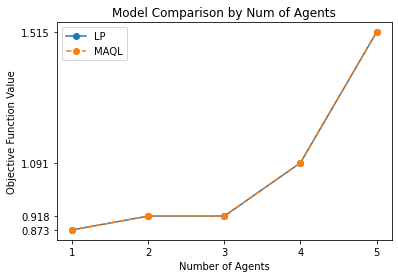

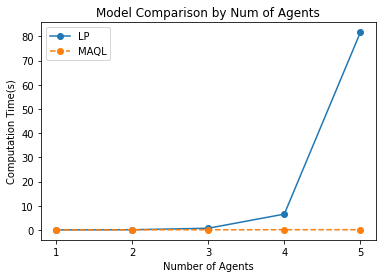

In [ ]:
num_of_agents = 1
lp_agent_limit = 5
maql_agent_limit = 5

stored_num_of_agents = []
stored_reward_values_ql = []
stored_obj_values_lp = []
stored_ql_comp_time = []
stored_lp_comp_time = []

while num_of_agents <= maql_agent_limit:

  print("Num of Agents:", num_of_agents)

  stored_num_of_agents.append(num_of_agents)

  if num_of_agents <= lp_agent_limit: 
    lp_optimal_policy, lp_obj_func_value, lp_time_elapsed = lp_model()
    stored_obj_values_lp.append(lp_obj_func_value)
    stored_lp_comp_time.append(lp_time_elapsed)
    print("LP Completed")

  stats, ql_optimal_policy, ql_reward_func_value, ql_time_elapsed = ql_model()
  stored_reward_values_ql.append(abs(ql_reward_func_value))
  stored_ql_comp_time.append(ql_time_elapsed)
  print("MAQL Completed\n")

  num_of_agents += 1

print("\n")
performance_plot()